In [1]:
%matplotlib inline

In [2]:
import numpy as np
import nibabel as nb
import nipype.interfaces.fsl as fsl
import matplotlib.pyplot as plt
import seaborn as sns
import nipype.interfaces.utility as util
import nipype.interfaces.nipy as nipy
import nipype.interfaces.ants as ants
import nipype.interfaces.afni as afni
import nipype.algorithms.rapidart as ra
from nipype.interfaces.utility import Function
from functions import strip_rois_func, motion_regressors, median, selectindex, nilearn_denoise, weighted_avg, pca_denoising
from nilearn.image import high_variance_confounds

/home/barbara/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Python2 support is deprecated and will be removed in a future release. Consider switching to Python3.
  del sys.path[0]


In [10]:
in_dir = '/home/barbara/Desktop/Data/Results/20190419_090309_BC_LC_mice4_1_2_nifti/BCLCmice4/BCLCmice4_18/'
orig = nb.load('/home/barbara/Desktop/Data/Results/20190419_090309_BC_LC_mice4_1_2_nifti/BCLCmice4/BCLCmice4_18/BCLCmice4_18.nii.gz')

In [11]:
orig_data = orig.get_data()

In [12]:
mean_ts_before = np.average(orig_data, axis=(0,1,2))

vol_to_remove = 15
motion_norm = 0.3
z_thr = 3
tr = 3
bandpass = [0.1, 0.01]  # rather 0.3 but too high for our temporal resolution

mean_ts_after = np.average(orig_data[:,:,:,vol_to_remove:], axis=(0,1,2))

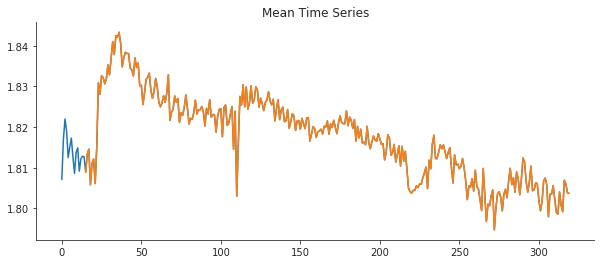

In [13]:
sns.set_style("ticks")
fig = plt.figure(figsize=(10,4))
plt.plot(mean_ts_before)
plt.plot(np.linspace(vol_to_remove, orig_data.shape[3]-1, orig_data.shape[3]-vol_to_remove), mean_ts_after)
plt.title("Mean Time Series")
sns.despine()

In [15]:
method = np.load(in_dir + 'BCLCmice4_18_method.npy')
#method.npy file

In [16]:
method_dict = method[()]

In [17]:
method_dict['ObjOrderList']

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14.,  1.,  3.,  5.,  7.,  9.,
       11., 13.])

In [18]:
moco = nipy.SpaceTimeRealigner(in_file = (in_dir + 'BCLCmice4_18.nii.gz'),
                               slice_times = 'asc_alt_2', tr = 2, slice_info = [2,1])

In [19]:
result = moco.run()

/home/barbara/anaconda3/lib/python2.7/site-packages/nipy/algorithms/statistics/__init__.py:9: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import intvol, rft, onesample, formula
/home/barbara/anaconda3/lib/python2.7/site-packages/nipy/algorithms/statistics/__init__.py:9: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 176
  from . import intvol, rft, onesample, formula
/home/barbara/anaconda3/lib/python2.7/site-packages/nipy/algorithms/registration/resample.py:15: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._registration import (_cspline_transform,
/home/barbara/anaconda3/lib/python2.7/site-packages/nipy/algorithms/registration/resample.py:15: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 176
  from ._registration import (_cspline_transform,
/home/barbara/anaconda

In [20]:
result.outputs


out_file = /home/barbara/Desktop/python_scripts/corr_BCLCmice4_18.nii.gz
par_file = /home/barbara/Desktop/python_scripts/BCLCmice4_18.nii.gz.par

In [21]:
#par_file = np.genfromtxt('/home/barbara/Desktop/python_scripts/BCLCmice1_18.nii.gz.par')
par_file = np.genfromtxt(result.outputs.par_file)
corr_file = result.outputs.out_file

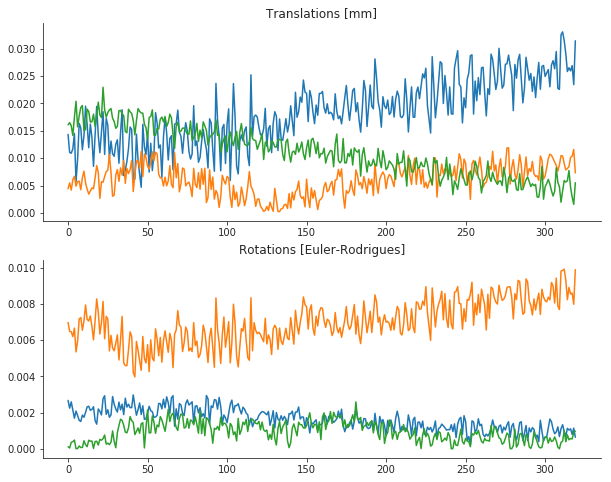

In [22]:
sns.set_style("ticks")
fig = plt.figure(figsize = (10,8))
fig.add_subplot(2,1,1)
for i in [0,1,2]:
    plt.plot(abs(par_file[:,i]))
    plt.title("Translations [mm]")
fig.add_subplot(2,1,2)
for i in [3,4,5]:
    plt.plot(abs(par_file[:,i]))
    plt.title("Rotations [Euler-Rodrigues]")
sns.despine()

In [23]:
# compute median
#input_file = '/home/barbara/Desktop/python_scripts/corr_BCtestmice1_17.nii.gz' #corrected motion artifacts

median_calc = util.Function(input_names=['in_files'],
                            output_names = ['median_file'],
                            function = median)

median_calc.inputs.in_files = result.outputs.out_file

# output from moco.run -- corr_blah.nii.gz

In [24]:
mean_image = median_calc.run()

<string>:25: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
<string>:25: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0


In [25]:
mean_image.outputs


median_file = /home/barbara/Desktop/python_scripts/corr_BCLCmice4_18_median.nii.gz

In [26]:
# bias field correction
biasfield = ants.N4BiasFieldCorrection(
                    input_image = (mean_image.outputs.median_file),
                    dimension = 3,
                    n_iterations = [150,100,50,30], convergence_threshold = 1e-11,
                    bspline_fitting_distance = 10, bspline_order = 4,
                    shrink_factor = 2,
                    output_image = ('func_median.nii.gz'))
# input file - output from mean image

In [27]:
biasfield_corr = biasfield.run()

In [28]:
biasfield_corr.outputs


bias_image = <undefined>
output_image = /home/barbara/Desktop/python_scripts/func_median.nii.gz

In [29]:
#compute functional mask
func_mask = afni.Automask(in_file = biasfield_corr.outputs.output_image,
                          dilate = 1, args = '-peels 3',
                          outputtype = 'NIFTI_GZ', out_file = '/home/barbara/Desktop/python_scripts/func_mask.nii.gz') 
# in_file - output image from biasfield

In [30]:
mask = func_mask.run()

190423-10:19:07,710 nipype.interface INFO:
	 stderr 2019-04-23T10:19:07.710532:++ 3dAutomask: AFNI version=AFNI_19.0.26 (Mar 20 2019) [64-bit]
190423-10:19:07,712 nipype.interface INFO:
	 stderr 2019-04-23T10:19:07.710532:++ Authored by: Emperor Zhark
190423-10:19:07,718 nipype.interface INFO:
	 stderr 2019-04-23T10:19:07.718490:*+ WARNING:   If you are performing spatial transformations on an oblique dset, 
190423-10:19:07,720 nipype.interface INFO:
	 stderr 2019-04-23T10:19:07.718490:  such as /home/barbara/Desktop/python_scripts/func_median.nii.gz,
190423-10:19:07,722 nipype.interface INFO:
	 stderr 2019-04-23T10:19:07.718490:  or viewing/combining it with volumes of differing obliquity,
190423-10:19:07,724 nipype.interface INFO:
	 stderr 2019-04-23T10:19:07.718490:  you should consider running: 
190423-10:19:07,725 nipype.interface INFO:
	 stderr 2019-04-23T10:19:07.718490:     3dWarp -deoblique 
190423-10:19:07,727 nipype.interface INFO:
	 stderr 2019-04-23T10:19:07.718490:  on th

In [31]:
mask.outputs


brain_file = /home/barbara/Desktop/python_scripts/func_median_masked.nii.gz
out_file = /home/barbara/Desktop/python_scripts/func_mask.nii.gz

In [32]:
# artefact detection
artefact = ra.ArtifactDetect(realigned_files = result.outputs.out_file,
                             realignment_parameters = result.outputs.par_file,
                             mask_file = mask.outputs.out_file,
                             save_plot=True,
                             use_norm=True,
                             parameter_source='NiPy',
                             mask_type='file',
                             norm_threshold=motion_norm,
                             zintensity_threshold=z_thr,
                             use_differences=[True,False])
# realigned files - out file do moco.run
# realignment parameters - par file do moco.run
# mask file - out file do func mask.run

In [33]:
artefact_corr = artefact.run()

/home/barbara/anaconda3/lib/python2.7/site-packages/nipype/algorithms/rapidart.py:542: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/barbara/anaconda3/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/barbara/anaconda3/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/barbara/.local/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/barbara/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/barbara/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py

In [34]:
artefact_corr.outputs


displacement_files = <undefined>
intensity_files = /home/barbara/Desktop/python_scripts/global_intensity.corr_BCLCmice4_18.txt
mask_files = /home/barbara/Desktop/python_scripts/mask.corr_BCLCmice4_18.nii.gz
norm_files = /home/barbara/Desktop/python_scripts/norm.corr_BCLCmice4_18.txt
outlier_files = /home/barbara/Desktop/python_scripts/art.corr_BCLCmice4_18_outliers.txt
plot_files = /home/barbara/Desktop/python_scripts/plot.corr_BCLCmice4_18.png
statistic_files = /home/barbara/Desktop/python_scripts/stats.corr_BCLCmice4_18.txt

In [35]:
# Motion regressors calculations

motreg = util.Function(input_names = ['motion_params', 'order','derivatives'],
                            output_names = ['out_files'],
                            function = motion_regressors)
                 
motreg.inputs.order = 1
motreg.inputs.derivatives = 0
motreg.inputs.motion_params = result.outputs.par_file
# motreg motion params - par file do moco.run

In [36]:
motion_reg = motreg.run()

In [37]:
motion_reg.outputs


out_files = ['/home/barbara/Desktop/python_scripts/motion_regressor_der2_ord2.txt']

In [38]:
# Nuisance regression

regress = util.Function(input_names = ['in_file', 'brain_mask', 'outlier_file','motreg_file', 'bandpass', 'tr'], 
                        output_names = ['denoised_img', 'denoised_data','confounds'],
                        function = nilearn_denoise)
regress.inputs.tr = tr
regress.inputs.bandpass = bandpass
regress.inputs.in_file = result.outputs.out_file
regress.inputs.brain_mask = '/home/barbara/Desktop/python_scripts/func_mask.nii.gz'
regress.inputs.outlier_file = artefact_corr.outputs.outlier_files
regress.inputs.motreg_file = '/home/barbara/Desktop/python_scripts/motion_regressor_der0_ord1.txt'

# in file - out file do moco
# brain mask - out file do func mask
# outlier file - outlier files do artefact - TEM DE SE ALTERAR
# motreg file - output do motion_reg

In [39]:
nuis_regress = regress.run()

/home/barbara/anaconda3/lib/python2.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


In [40]:
nuis_regress.outputs


confounds = /home/barbara/Desktop/python_scripts/all_confounds.txt
denoised_data = /home/barbara/Desktop/python_scripts/corr_BCLCmice4_18_denoised.npy
denoised_img = /home/barbara/Desktop/python_scripts/corr_BCLCmice4_18_denoised.nii.gz

In [41]:
### END OF PREPROCESSING ###

In [42]:
# ICA

ica = fsl.MELODIC(in_files = nuis_regress.outputs.denoised_img,
                  mask = '/home/barbara/Desktop/python_scripts/func_mask.nii.gz', 
                  bg_image = mask.outputs.brain_file,
                  out_dir = '/home/barbara/Desktop/python_scripts/ica/',
                  no_bet = True, bg_threshold = 1, tr_sec = 2, report = True)
ica.run()

In [174]:
# Outputs of preprocessing steps + ICA are now in Results folder (nifti -- preprocess_X)